UDA Assignment 2



In [ ]:


"""
Before starting, make sure to have these packages:
beautifulsoup4==4.10.0
requests==2.26.0
lxml
"""

!pip install beautifulsoup4
!pip install requests
!pip install lxml
!pip install vaderSentiment
!pip install scraper
!pip install tqdm

  Created wheel for scraper: filename=scraper-0.1.0-py3-none-any.whl size=3486 sha256=9f0ca6c5340533ef2736976c0b096388732aacd83950c3a1792949071d23a368
  Stored in directory: /root/.cache/pip/wheels/da/8b/92/da1812cedf0e0d0cb672b1e603021ca30c0a104d34fc1b2a3a
Successfully built scraper


In [ ]:
# Scraper
'''
Scraper for: https://www.beeradvocate.com/beer/top-rated/
The below file will output a JSON file with ->
5-6 thousand reviews for various beers
this means we will scrape approximately 24 reviews per 250 beers
'''
import os
import sys
from bs4 import BeautifulSoup
import requests
import json
import re
from requests.models import Response
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# function to print sentiments of the sentence.
def sentiment_score(sentence):

	# Create a SentimentIntensityAnalyzer object.
	sid_obj = SentimentIntensityAnalyzer()

	# polarity_scores method of SentimentIntensityAnalyzer
	# object gives a sentiment dictionary which contains pos, neg, neu, and compound scores.
	sentiment_dict = sid_obj.polarity_scores(sentence)
	
	return sentiment_dict

# scraper object will be the entry point to the scraping functionality

class Scraper:
    def __init__(self, url, numReviews, verbose=False):
        self.url = url
        # approximate number of reviews to pull per beer (may not be exact)
        self.numReviews = numReviews
        self.verbose = verbose
        self.review_df = None
        self._links = []
        self._soup_home = None

    def _makeRequest(self):
        res = requests.get(self.url)
        src = res.content
        self._soup_home = BeautifulSoup(src, 'lxml')
        if self.verbose:
            print('The URL was successfully called')

    def _scrapeReviews(self):
        html_td = self._soup_home.find_all(
            'td', attrs={'align': 'left', 'class': 'hr_bottom_light'})
        count = 0
        for td in html_td:
            if td.a:
                if self.verbose:
                    print(f'Link: {td.a["href"]} added')
                self._links.append(td.a['href'])
                count += 1

        print(f"{count} links collected")

        # scrape for reviews at each link
        # {name: [reviews], name: [reviews]}
        count = 0
        with open('reviews.json', 'w') as out_file:
            data = {}
            s = ' '
            for link in self._links: # for each page 
                res = requests.get('https://www.beeradvocate.com/' + link)
                src = res.content
                indv_soup = BeautifulSoup(src, 'lxml')
                html_divs = indv_soup.find_all(
                    'div', attrs={'id': 'rating_fullview_content_2'})
                beer_name = indv_soup.find(
                    'div', attrs={'class': 'titleBar'}).h1.contents[0]
                
                data_reviews = []
                print(f'getting reviews for: {beer_name}')

                for html_div in html_divs: # for each review
                    full_entry = {}
                    review_text = html_div.contents
                    review_text = list(map((lambda x : str(x).strip()), review_text))
                    
                    # regex to find rating
                    pattern = r'^(<span class="muted">)(.+?(?=</span>))'
                    rating_matches = []
                    for item in review_text:
                        match = re.search(pattern, item)
                        if match:
                            rating_matches.append(match.group(2))
                    # extract rating for beer
                    for m in rating_matches:
                        if 'look' in m:
                            full_entry['rating'] = m
                
                    f = list(filter(lambda x : x.find('<') == -1 and x.find('rDev') == -1, review_text)) # filtering elements and wildcards
                    f = s.join(f)
                    full_entry['review'] = f

                    # perform sentiment analysis on review 
                    full_entry['sentiment'] = sentiment_score(f)

                    data_reviews.append(full_entry)
                
                data[beer_name] = data_reviews
               
            json_dumps = json.dumps(data, indent=4)
            out_file.write(json_dumps)
            print('JSON file was written to (reviews.json)')

    def getReviews(self):
        try:
            self._makeRequest()
        except requests.RequestException as e:
            print('There was a request exception')
            print(e)

        # scrape review _homeobjects
        self._scrapeReviews()

    def getReviewsForSpecificBeer(self, beerName: str):
        #TODO: Would be nice to have a function like this
        pass

if __name__ == "__main__":
    # create a Scraper object and call functions
    url = 'https://www.beeradvocate.com/beer/top-rated/'
    num_rev = 24
    scraper = Scraper(url, numReviews=num_rev, verbose=True)
    scraper.getReviews()

In [ ]:
## importing scraper
from scraper.scraper import Scraper

SyntaxError: ignored

In [ ]:
url = 'https://www.beeradvocate.com/beer/top-rated/'
num_rev = 24
scraper = Scraper(url, numReviews=num_rev)

# scrape reviews (exports JSON file)
"""
Note, the scraper will get 24 reviews per 250 beers on the frotn page of the URL
Please look inside of reviews.json to get an idea of how the data is formatted
"""
scraper.getReviews()

250 links collected
getting reviews for: Kentucky Brunch Brand Stout
getting reviews for: Marshmallow Handjee
getting reviews for: Hunahpu's Imperial Stout - Double Barrel Aged
getting reviews for: Barrel-Aged Abraxas
getting reviews for: Heady Topper
getting reviews for: Pliny The Younger
getting reviews for: Mornin' Delight
getting reviews for: King Julius
getting reviews for: King JJJuliusss
getting reviews for: SR-71
getting reviews for: Very Hazy
getting reviews for: CBS (Canadian Breakfast Stout)
getting reviews for: Fundamental Observation
getting reviews for: Pliny The Elder
getting reviews for: Hunahpu's Imperial Stout - Laird's Apple Brandy Barrel
getting reviews for: Assassin
getting reviews for: Fou' Foune
getting reviews for: Barrel Aged Imperial German Chocolate Cupcake Stout
getting reviews for: Juice Machine
getting reviews for: Julius
getting reviews for: Very Green
getting reviews for: Zenne Y Frontera
getting reviews for: Abner
getting reviews for: Double Sunshine
ge

In [ ]:
## importing data (example of how the data is stored in the JSON file)
import pandas as pd
import json

file = open("reviews.json")
data = json.load(file)
file.close()

beer_names = [name for name in data]

count = 0
for beer_name in beer_names:
    if count > 2:
        break
    print(data[beer_name][0])
    count += 1

{'rating': 'look: 4.5 | smell: 5 | taste: 5 | feel: 4.75 | overall: 4.75', 'review': ' 2020 vintage drank 10/22/21 Incredible smell as soon as bottle was opened. Rich maple, chocolate, syrup breakfast in a glass. Incredibly smooth. Not a ton of bourbon flavor, and no alcohol burn. Not as thick as some TG stouts like assassin, but still an incredible beer and glad I chased it. Definitely one of the best', 'sentiment': {'neg': 0.023, 'neu': 0.721, 'pos': 0.256, 'compound': 0.9531}}
{'rating': 'look: 5 | smell: 4.25 | taste: 4.75 | feel: 4.5 | overall: 4.5', 'review': 'Like slow dancing with Aretha Franklin, this one has soul. Hot damn, I feel like I can lasso a T. rex. Uhhh huh, I can hurdle that St. Louis arc…  Raul.Is.feeling.this.', 'sentiment': {'neg': 0.076, 'neu': 0.784, 'pos': 0.14, 'compound': 0.3182}}
{'rating': 'look: 5 | smell: 5 | taste: 4.5 | feel: 5 | overall: 4.75', 'review': 'This amazing beer combines tobacco, peppers, vanilla, and what tastes like brandy into the quinte

Task B

In [ ]:
## Imports
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.manifold import MDS
import sklearn.datasets as dt
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import re
import nltk
import requests
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
## importing data (example of how the data is stored in the JSON file)
import pandas as pd
import json

file = open("reviews.json")
data = json.load(file)
file.close()

beer_names = [name for name in data]

count = 0
with_stop_words = []

for beer_name in beer_names:
    '''if count > 0:
        break'''
    #print(data[beer_name][0]['review'])
    for word in list(set(data[beer_name][0]['review'].split())): 
        with_stop_words.append(word.strip().lower()) # lower
        
no_stop_words = []
for word in with_stop_words:
    
    if word.lower() not in stopwords.words('english'):
        
        no_stop_words.append(word.lower()) # change from ihsan
    
s_words_withstopwords = pd.Series(with_stop_words)
s_words_withoutstopwords = pd.Series(no_stop_words)

import nltk
with_stop_word_dist = nltk.FreqDist(s_words_withstopwords)
without_stop_word_dist = nltk.FreqDist(s_words_withoutstopwords)

In [ ]:
s_words_withoutstopwords = pd.Series(without_stop_word_dist)
s_words_withstopwords = pd.Series(with_stop_word_dist)

In [ ]:
s_words_withoutstopwords_sorted= s_words_withoutstopwords.sort_values(ascending= False)
s_words_withstopwords_sorted= s_words_withstopwords.sort_values(ascending= False)

In [ ]:
df_without_stop = pd.DataFrame()
df_without_stop['words'] = s_words_withoutstopwords_sorted.keys()
df_without_stop['count'] = s_words_withoutstopwords_sorted.values
df_without_stop.to_csv('words_no_stop.csv')

df_with_stop = pd.DataFrame()
df_with_stop['words'] = s_words_withstopwords_sorted.keys()
df_with_stop['count'] = s_words_withstopwords_sorted.values
df_with_stop.to_csv('words_with_stop.csv')

Link For Task B- https://www.dummies.com/food-drink/drinks/beer/beer-for-dummies-cheat-sheet/

In [ ]:
words_no_stop = pd.read_csv("words_no_stop.csv")

In [ ]:
words_no_stop[15:30]

Unnamed: 0    words  count
15          15   bottle     45
16          16        -     45
17          17  bourbon     44
18          18    great     44
19          19    sweet     44
20          20   poured     43
21          21    smell     43
22          22      bit     43
23          23    notes     41
24          24     feel     41
25          25     nose     40
26          26    color     40
27          27    thick     40
28          28    beer.     39
29          29    aroma     38

In [ ]:
partb_attributes = open("attributes.txt","w+")
partb_attributes.write('dark sweet thick')
partb_attributes.close()

Task C

In [ ]:
import pandas as pd 
import json

file = open("reviews.json")
data = json.load(file)
file.close()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

def create_dataframe(matrix, tokens):

    doc_names = [f'review_{i+1}' for i, _ in enumerate(matrix)]
    df = pd.DataFrame(data=matrix, index=doc_names, columns=tokens)
    return(df)

In [ ]:
attributes_file = open("attributes.txt","r")
attr = attributes_file.readline()
attributes_file.close()

In [ ]:
attr

'dark sweet thick'

In [ ]:
product_names = []
product_reviews = []
similarity_scores = []
count_vectorizer = CountVectorizer()

beer_names = [name for name in data]
count = 0 
for beer_name in beer_names:
    for i in range(0,len(data[beer_name])):
        reviews = (data[beer_name][i]['review'].split('\n'))

        for review in reviews:
            vector_matrix = count_vectorizer.fit_transform([review,attr])
            tokens = count_vectorizer.get_feature_names()
            vector_matrix.toarray()
            create_dataframe(vector_matrix.toarray(),tokens)
            cosine_similarity_matrix = cosine_similarity(vector_matrix)
            #create_dataframe(cosine_similarity_matrix,[review,attr])

            count += 1
            #print(count)
            
            score = cosine_similarity_matrix[0][1]
            product_names.append(beer_name)
            product_reviews.append(review)
            similarity_scores.append(score)

In [ ]:
attrs = attr.split(' ')
df_eachattr = pd.DataFrame()

dark_score = []
sweet_score = []
thick_score = []
beer_names = [name for name in data]
count = 0 
for beer_name in beer_names:
    for i in range(0,len(data[beer_name])):
        reviews = (data[beer_name][i]['review'].split('\n'))

        for review in reviews:
            for k in range(3):
                vector_matrix = count_vectorizer.fit_transform([review,attrs[k]])
                tokens = count_vectorizer.get_feature_names()
                vector_matrix.toarray()
                create_dataframe(vector_matrix.toarray(),tokens)
                cosine_similarity_matrix = cosine_similarity(vector_matrix)
                #create_dataframe(cosine_similarity_matrix,[review,attr])
                score = cosine_similarity_matrix[0][1]

                count += 1
                #print(count)
                if k == 0:
                    dark_score.append(score)
                elif k == 1:
                    sweet_score.append(score)
                elif k == 2:
                    thick_score.append(score)
        
#df['product_name'] = product_names        
df_eachattr['dark score'] = dark_score
df_eachattr['sweet score'] = sweet_score
df_eachattr['thick score'] = thick_score

In [ ]:
output = pd.DataFrame()

output['product_name'] = product_names
output['product_review'] = product_reviews
output['similarity_score'] = similarity_scores
    
output.to_csv('cosine_similarity.csv', index=False)
output.head()

product_name  ... similarity_score
0  Kentucky Brunch Brand Stout  ...         0.066667
1  Kentucky Brunch Brand Stout  ...         0.000000
2  Kentucky Brunch Brand Stout  ...         0.000000
3  Kentucky Brunch Brand Stout  ...         0.088302
4  Kentucky Brunch Brand Stout  ...         0.000000

[5 rows x 3 columns]

In [ ]:
df_eachattr.head()

dark score  sweet score  thick score
0         0.0          0.0     0.115470
1         0.0          0.0     0.000000
2         0.0          0.0     0.000000
3         0.0          0.0     0.152944
4         0.0          0.0     0.000000

In [ ]:

df_eachattr = pd.DataFrame()


df_eachattr['product_name'] = product_names        
df_eachattr['dark score'] = dark_score
df_eachattr['sweet score'] = sweet_score
df_eachattr['thick score'] = thick_score

df_eachattr
df_eachattr.to_csv("Attr_by_review.csv")

Task D- Sentiment Analysis already done in the scraper. Sentiment scores and analysis available in reviews.json

Task E

In [ ]:
import numpy as np
import pandas as pd
import json

In [ ]:
  #Grab cosine_similarity csv and turn it to dictionary with average similarity score for each product
  def cosine_sim_convertor(name):
    cos_sim = pd.read_csv(name)
    cos_sim = cos_sim.groupby('product_name').agg({
      'similarity_score': np.mean
    })
    cos_sim = cos_sim.to_dict('dict')
    cos_sim_final = cos_sim['similarity_score']
    return cos_sim_final

In [ ]:
#grabs all senti scores from json and turn it into dictionary with average senti score for each product
def senti_score_convertor(name):
  file = open(name)
  reviews = json.load(file)
  file.close()
  beer_names = [name for name in reviews]
  d = {}
  for name in beer_names:
    senti = []
    for item in reviews[name]:
      senti.append(item['sentiment']['compound'])
    d[name] = np.array(senti).mean() 
  return d

In [ ]:
#consolidates senti scores and review scores into one dataframe
def sim_senti_consolidate(cos_sim,senti):
  d = {}
  for item in cos_sim:
    d[item] = {'sentiment':senti[item], 'similarity': cos_sim[item]}
  final_table = pd.DataFrame(d).T
  final_table.index.name = 'name'
  return final_table

In [ ]:
#Assume that the data will be in the form of a table that has the following columns: product name, product review, similarity score, sentiment score
#Outputs top 3 products with highest sum of average of sentiment and and average of similarity score 
def consolidate_table(table):
  table['sentsim'] = table['similarity']+table['sentiment']
  return table.sort_values('sentsim',ascending=False).head(3)

In [ ]:
#cosine similairty top 3 recs
review_scores = cosine_sim_convertor('cosine_similarity.csv')
senti_scores = senti_score_convertor('reviews.json')
final_table = sim_senti_consolidate(review_scores,senti_scores)
df_average = consolidate_table(final_table)
df_average

sentiment  ...   sentsim
name                                                           ...          
Hellaboozie (Bourbon Barrel Aged Dark Lord Impe...   0.883440  ...  1.041784
Genealogy Of Morals - Bourbon Barrel-Aged            0.904744  ...  0.991424
Expedition Stout - Bourbon Barrel-Aged               0.900776  ...  0.986892

[3 rows x 3 columns]

Task F

In [ ]:
#Makes vector CSV
import spacy
!python -m spacy download en_core_web_md
import en_core_web_md

nlp = en_core_web_md.load()
import pandas as pd 
import json

file = open("reviews.json")
data = json.load(file)
file.close()

def cosine_similarity(review):
    processed_review = nlp(review)
    score = processed_review.similarity(processed_attr)
    return score
attr = "Dark Sweet Thick"
processed_attr = nlp(attr)

#attributes_file = "attributes.txt"
#attrs = pd.read_csv(r"attributes.txt", delimiter=" ", header=None)

product_names = []
product_reviews = []
similarity_scores = []
attrs = ['Dark', 'Sweet', 'Thick']
    
beer_names = [name for name in data]
count = 0 
for beer_name in beer_names:
    for i in range(0,len(data[beer_name])):
        reviews = (data[beer_name][i]['review'].split('\n'))

        for review in reviews:
            
            score = cosine_similarity(review[0])
            product_names.append(beer_name)
            product_reviews.append(review)
            similarity_scores.append(score)
            count += 1
            

output = pd.DataFrame()

output['product_name'] = product_names
output['product_review'] = product_reviews
output['similarity_score'] = similarity_scores
output.to_csv('cosine_similarity_bow.csv', index=False)


     |████████████████████████████████| 96.4 MB 1.6 MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-py3-none-any.whl size=98051302 sha256=136970c207bb4c4048aae658d5ecdf8b50a3de6112516a00a1121124815bc6eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-vyfe8fzt/wheels/69/c5/b8/4f1c029d89238734311b3269762ab2ee325a42da2ce8edb997
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__main__", mod_spec)
/usr/lib/python3.7/runpy.py:193: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  "__mai

In [ ]:
#using word embeddings instead of BoW top 3 recs
review_scores_vector = cosine_sim_convertor('cosine_similarity_bow.csv')
final_table = sim_senti_consolidate(review_scores_vector,senti_scores)
df_average = consolidate_table(final_table)
df_average

sentiment  ...   sentsim
name                                                           ...          
Cable Car                                            0.904356  ...  1.122975
Genealogy Of Morals - Bourbon Barrel-Aged            0.904744  ...  1.117866
Hellaboozie (Bourbon Barrel Aged Dark Lord Impe...   0.883440  ...  1.116597

[3 rows x 3 columns]

In [ ]:
vector_bow = sim_senti_consolidate(review_scores,review_scores_vector)
vector_bow.rename(columns={'sentiment': 'vector'}, inplace=True)
vector_bow['sentsim'] = (vector_bow['vector']-vector_bow['similarity'])/vector_bow['similarity']

In [ ]:
#Percent change from using vector vs similarity
vector_bow[vector_bow['sentsim']<100].sort_values('sentsim',ascending=False).head(20)

vector  similarity    sentsim
name                                                             
Fou' Foune                        0.193980    0.001960  97.951328
Coolship Red                      0.201236    0.004106  48.013716
Juicy                             0.210939    0.004890  42.137994
Dorothy (Wine Barrel Aged)        0.222086    0.005432  39.883695
Oude Geuze Golden Blend           0.193196    0.004949  38.037426
Cellarman Barrel Aged Saison      0.161653    0.004742  33.086434
Pliny The Elder                   0.248378    0.007364  32.728309
Flora                             0.209410    0.006483  31.300195
Fuzzy                             0.190501    0.006004  30.727904
The Broken Truck                  0.207526    0.006904  29.060182
Gueuze 100% Lambic                0.202723    0.007165  27.294648
Lou Pepe - Gueuze                 0.196578    0.007265  26.057117
Cable Car                         0.218619    0.008118  25.931014
Double Galaxy                     0.213981    0.008104  25.404530
Bodhi                             0.234802    0.009359  24.088588
Focal Banger                      0.198982    0.007988  23.910029
In Perpetuity                     0.210562    0.008534  23.674696
La Fosse                          0.249598    0.010688  22.354022
Julius                            0.228281    0.010047  21.722253
Oude Geuze Cuvée Armand & Gaston  0.189872    0.009004  20.086980

Task G

In [ ]:
#takes ratings from json and puts it into dictionary
def rating_score_convertor(name):
  file = open(name)
  reviews = json.load(file)
  file.close()
  beer_names = [name for name in reviews]
  d = {}
  for name in beer_names:
    senti = []
    for item in reviews[name]:
      try:
        rating = item['rating'].split(' | ')[4].split(': ')[1]
        senti.append(float(rating))
      except:
        pass
    d[name] = np.array(senti).mean() 
  return d

In [ ]:
ratings = rating_score_convertor('reviews.json')

In [ ]:
#adds overall rating column to table with sentiment, similarity and sentsim. Sorted by overall rating
def rating_consolidate(cos_sim,senti,rating):
  d = {}
  for item in cos_sim:
    d[item] = {'sentiment':senti[item], 'similarity': cos_sim[item], 'overall_rating': rating[item]}
  final_table = pd.DataFrame(d).T
  final_table.index.name = 'name'
  final_table['sentsim'] = final_table['similarity']+final_table['sentiment']
  return final_table.sort_values('overall_rating',ascending=False)

In [ ]:
table_w_ratings = rating_consolidate(review_scores,senti_scores,ratings)

In [ ]:
table_w_ratings

sentiment  ...   sentsim
name                                                ...          
Chemtrailmix                              0.786360  ...  0.872915
Vanilla Bean Assassin                     0.826437  ...  0.889649
Blessed                                   0.784764  ...  0.888256
SR-71                                     0.776524  ...  0.861858
Kentucky Brunch Brand Stout               0.754744  ...  0.807491
...                                            ...  ...       ...
La Fosse                                  0.654616  ...  0.665304
Bourbon Barrel Black Maple                0.613604  ...  0.683361
Fort Point Pale Ale - Mosaic Dry Hopped   0.630976  ...  0.654639
Last Snow                                 0.780516  ...  0.825271
Emerald Grouper                           0.811792  ...  0.862802

[250 rows x 4 columns]

In [ ]:
table_w_ratings.to_csv('overall_rating.csv', index=True)

Analysis

# Task F:

Top 3 Recommendations based on Bag of Words:



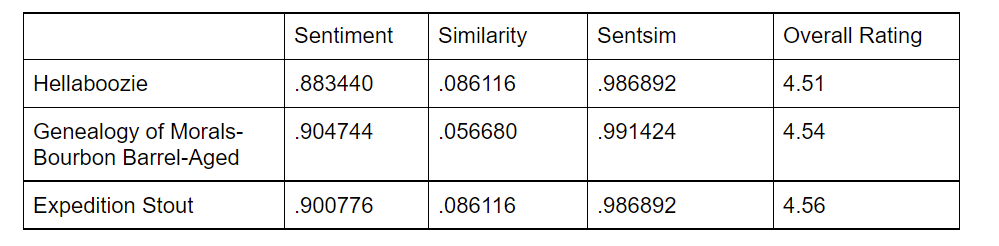




Top 3 Recommendations based on Word Embeddings:



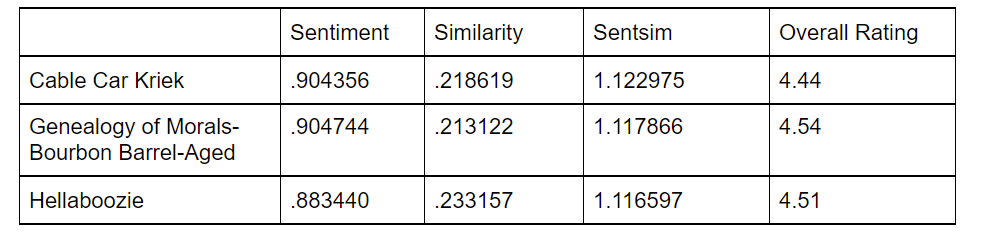


As seen in the tables above there is a difference in the recommendations provided by a system that used a word embedding method versus a bag of words method. While Genealogy of Morals and Hellaboozie remain constant in our suggestions, Cable Car and Expedition Stout switch in and out. Most of this has to do with the similarity scores. The similarity scores are much higher using the word embedding method than bag of words. This causes the Sentsim scores to increase as well, which caused Expedition Stout to be removed from the top 3 recommendations. The increase in similarity scores is what leads us to choose a recommender system based on word embeddings. However we do acknowledge the deficiencies of word vectors. There is actually a higher % of attribute mentions and higher attribute scores (Sweet score etc) in Expedition Stout reviews than in Cable Car Kriek. This can be due to the fact that certain attributes are mentioned closely together often which bag of words can recognize well but word embeddings cannot. However, we believe the significant increase in similarity scores is key to creating a more robust recommender system hence our choice to move forward with the word embedding method. 


Task G:

Ignoring the similarity and feature sentiment scores leads us to recommend the below as our top three beers:

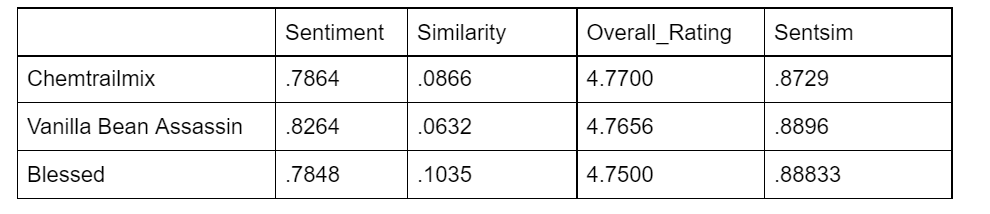

These suggestions would not be useful based on our customers looking for beers that are malty, hoppy, and bold. Analyzing the attribute scores (sweet score, dark score etc.) for each beer we noticed that only one review out of all of the reviews for the top three ranked beers even had an attribute score. This demonstrated that these beers, even though they are highly ranked, do not meet our customers' taste in beverages. This is one of the issues about simply recommending the highest scoring product is that it is not a personalized recommendation. If the forum allowed individuals to rate sweetness or thickness then we might be able to use the highest ratings of those specific attributes to recommend beers more effectively based on tastes. 

Another thing to consider is the sentiment and similarity scores. The similarity scores for the top 3 highest beers are .1 or very small compared to those of our recommended beers (using the word vectors method, see in previous section). This suggests that the reviews are not closely correlated and they do not necessarily provide a general consensus of the beer. The sentiment scores are also much smaller suggesting that there is not that positive of an impression of these beers overall. Where the beers we recommended have much higher sentiment scores, around 90%. If you sort the beers by sentiment or sentsim score (avg similarity score + avg sentiment score), the top 3 recommended beers actually rank in the middle to the end of the pack. Another issue to consider is also sample size in regards to overall_ratings. Chemtrailmix, Vanilla Bean Assassin, and Blessed have far fewer reviews than our recommended beers. This difference in review size can play a major factor in why the overall ratings for those beers are higher than our suggestions. 

Overall we believed the recommender system we built using similarity score and word embeddings is more efficient than simply choosing the top 3 highest ranked beers as it takes into account the customers specific tastes to base suggestions on and addresses any disparity caused by sample size of reviews. 


